In [1]:
#!pip install torch==1.9.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.9.1+cpu torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torchaudio

In [1]:
#!pip install audtorch
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import random

from IPython.display import clear_output
import tqdm.notebook as tqdm
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
from torch import nn
from sklearn.metrics import classification_report

import torch.nn.functional as F

#import audtorch
%matplotlib inline

In [3]:
from utils.dataloader import make_sorted_dataloader, collate_with_paddings
from utils.chunk_dataset import ChunkDataSet
from utils.zip_dataset import ZippedDataSet

In [4]:
#train_ds = 
train_ds = ZippedDataSet('data/Data/train_chunk2s_msl0.zip', ChunkDataSet('./data/Data/train', chunk_size_s=2), rewrite=False, min_sample_len=0)
test_ds = ZippedDataSet('data/Data/test_chunk2s_msl0.zip', ChunkDataSet('./data/Data/test', chunk_size_s=2), rewrite=False, min_sample_len=0)

13734 chunks
zip_fname='data/Data/train_chunk2s_msl0.zip' exists! Using that archive
1680 chunks
zip_fname='data/Data/test_chunk2s_msl0.zip' exists! Using that archive


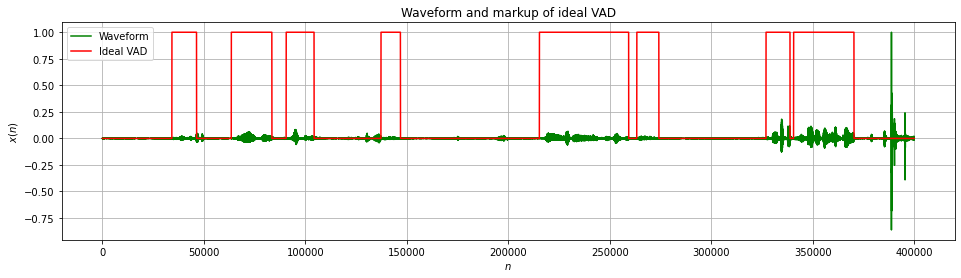

In [5]:
class ClsDatasetWrapper:
    def __init__(self, ds):
        self.ds = ds
        self.brackets_l = torch.Tensor([0,    0.45, 0.6, 0.8])
        self.brackets_r = torch.Tensor([0.45, 0.6,  0.8, 1.1])
    
    def __getitem__(self, index):
        item  = self.ds[index]
        l = item['labels'].mean() # .view(-1, 1)
        cls_labels = torch.where((self.brackets_l <= l) & (self.brackets_r > l))[0][0] # torch.nonzero((brackets_l <= l) & (brackets_r > l))[:, 1]
        #print(cls_labels)
        assert cls_labels.shape == l.shape, f'{cls_labels=} {l=}'
        item['cls_labels'] = cls_labels
        return item
    
    def __len__(self):
        return len(self.ds)

    def total_sec(self):
        return self.ds.total_sec()

    def size(self, index):
        return self.ds.size(index)
    
    def __getattr__(self, name):
        return getattr(self.ds, name)
    
train_cls_ds = ClsDatasetWrapper(train_ds)
test_cls_ds = ClsDatasetWrapper(test_ds)

In [6]:
# print(train_cls_ds[1]['feats'])
# t = torchaudio.transforms.TimeMasking(100)
# t.train()
# print(t(train_cls_ds[1]['feats']))
# t.eval()
# print(t(train_cls_ds[1]['feats']))


In [7]:
train_cls_ds[0]['feats'].shape

torch.Size([80, 46])

In [8]:
getattr(train_cls_ds.ds, 'min_sample_len', -1)

0

In [22]:


class EfficientNetASR(nn.Module):                                                                                                                                                                 
    def __init__(self, efficient_net_version='b0', num_cls=4, aug_prob=0.9):                                                                                                                                         
        super().__init__()
        assert efficient_net_version is not None
        self.aug_prob = aug_prob
        self.aug = nn.Sequential(torchaudio.transforms.TimeMasking(8),
                                        torchaudio.transforms.TimeMasking(8),
                                        torchaudio.transforms.FrequencyMasking(6),
                                        torchaudio.transforms.FrequencyMasking(6))
            
        self.efficientnet_model = EfficientNet.from_pretrained('efficientnet-%s' % efficient_net_version)                                                                                                                                                             
        self.efficientnet_model._conv_stem = Conv2dStaticSamePadding(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=(128, 188))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(1000, 256, bias=True)                                                                                                                                  
        self.head = nn.Linear(256, num_cls)
        #self.sig = torch.nn.Sigmoid()
        
    def forward(self, x):
        if self.training:
            p = random.random()
            if p <= self.aug_prob:    
                x = self.aug(x)
        else:
            x = self.aug(x)
        x = x.unsqueeze(dim=1)
        x = F.relu(self.efficientnet_model(x))
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.head(x)
        #print(x.shape)
        return x


In [23]:
def get_cls_weights(ds, num_classes=4):
    cls2num = [0]*num_classes
    for i in tqdm.tqdm(range(len(ds))):
        item = ds[i]
        cls2num[item['cls_labels']]+=1
    return torch.Tensor(cls2num)
get_cls_weights(train_cls_ds)

  0%|          | 0/13734 [00:00<?, ?it/s]

tensor([ 576., 4763., 7650.,  745.])

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [25]:
def get_criterion(train_ds, criterion='ce', device='cpu'):
    if criterion == 'ce':
        weights = get_cls_weights(train_cls_ds)
        return nn.CrossEntropyLoss(weight=(1/weights).to(device), ignore_index=-1)
    if criterion == 'focal':
        return FocalLoss()
    

In [26]:
def eval_reg(model, dataloader, device='cpu'):
    model.eval()
    raise NotImplementedError()
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch

            logits_mean = logits.mean(dim=1)#/pad_batch.sum(dim=1)
            y_mean = y_batch.sum(dim=1)/pad_batch.sum(dim=1)
            loss = ((y_mean - logits_mean)**2).mean().cpu().item()
            losses.append(loss)
    return np.mean(losses)

def eval_cls(model, dataloader, device='cpu', calc_report=True, criterion=None):
    model.eval()
    losses = []
    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
    truth = []
    predicted = [] 
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['cls_labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) 
            #print(logits.shape, y_batch.shape)
            loss = criterion(logits, y_batch)
            losses.append(loss.item())
            predicted.append(logits.argmax(dim=-1).cpu().numpy())
            truth.append(batch['cls_labels'].cpu().numpy())
    cr = None
    if calc_report:
        truth = np.concatenate(truth)
        predicted = np.concatenate(predicted)
        cr = classification_report(truth, predicted, target_names=[f'[{l:.2f},{r:.2f})' for l,r in zip([0,    0.45, 0.6, 0.8], [0.45, 0.6,  0.8, 1.1])])
    return np.mean(losses), cr


        
def train_per_chunk(model, train_dl, val_dl, 
                    epochs=10, 
                    device='cpu', 
                    lr=1e-3, 
                    gamma=0.95,
                    weight_decay=1e-6,
                    criterion=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
    
    train_losses = []
    val_losses = []
    last_val = float('inf')
    t1 = tqdm.tqdm(range(1, epochs+1))
    for e in t1:
        #print(f'Epoch {e}/{epochs}')
        #tqdm.tqdm
        losses = []
        t2 = (train_dl)
        for batch in t2:
            model.train()
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['cls_labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch         
            loss  = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

            t1.set_description(desc=f"Ep {e}, loss={losses[-1]:.5f}, val={last_val:.5f}")
            #break
        scheduler.step()
        train_losses.append(np.mean(losses))
        last_val, cr = eval_cls(model, val_dl, device=device, criterion=criterion, calc_report=False)
        val_losses.append(last_val)
        #print(cr)
        
    plt.figure(figsize=(8, 8)); plt.title('Train losses')
    plt.xlabel('iter') ; plt.ylabel('loss'); plt.grid()
    plt.plot(train_losses, label='train loss')
    val_losses = np.array(val_losses)
    val_losses[val_losses>2] = 2
    plt.plot(val_losses, label='test loss')
    plt.legend()
    plt.show()
    return model 

In [13]:
train_cls_ds.sizes

array([1.84, 1.92, 2.  , ..., 2.  , 2.  , 2.  ])

In [14]:
btz=128
device='cuda'
train_dl = make_sorted_dataloader(train_cls_ds, batch_size=btz, min_sample_len=0)
test_dl = make_sorted_dataloader(test_cls_ds, batch_size=btz, min_sample_len=0)
criterion = get_criterion(train_cls_ds, device)

Dataloader min_sample_len=0
SortedSampler remove 0 (13734 -> 13734)
Dataloader min_sample_len=0
SortedSampler remove 0 (1680 -> 1680)


  0%|          | 0/13734 [00:00<?, ?it/s]

In [15]:
len(test_dl)

14

In [16]:
model = EfficientNetASR('b1').to(device)
r = eval_cls(model, test_dl, device=device, criterion=criterion)
print(r[0])
print(r[1])

Loaded pretrained weights for efficientnet-b1
1.4199766857283456
              precision    recall  f1-score   support

 [0.00,0.45)       0.14      0.18      0.16       197
 [0.45,0.60)       0.36      0.09      0.15       726
 [0.60,0.80)       0.22      0.03      0.05       498
 [0.80,1.10)       0.15      0.66      0.24       259

    accuracy                           0.17      1680
   macro avg       0.22      0.24      0.15      1680
weighted avg       0.26      0.17      0.13      1680



Loaded pretrained weights for efficientnet-b1


  0%|          | 0/200 [00:00<?, ?it/s]

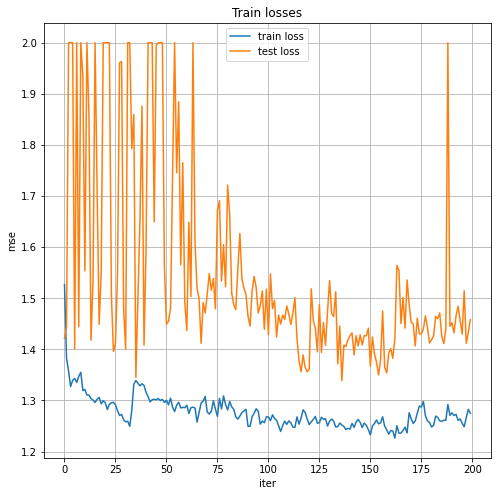

In [17]:
model = EfficientNetASR('b1').to(device)
#model = CNN_blstm().to(device)
model = train_per_chunk(model, 
                        train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
                        epochs=200, 
                        lr=1e-4,
                        weight_decay=1e-6, 
                        gamma=1,
                        device=device, 
                        criterion=criterion)
torch.save(model, 'models/it2/effnet.tmp.pt')
# train= val=0.01172. btz=40, epochs=60, lr=1e-4
# train= val=0.01155. btz=128, epochs=60, lr=1e-4
# train= val=. btz=128, epochs=60, lr=1e-3
# train= val=. btz=128, epochs=60, lr=1e-5
# mse^2 train= val=0.01417. btz=128, epochs=60, lr=1e-3


Loaded pretrained weights for efficientnet-b1


  0%|          | 0/200 [00:00<?, ?it/s]

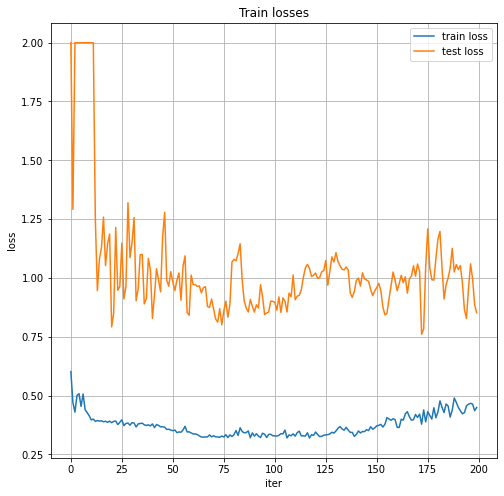

In [27]:
criterion = get_criterion(train_cls_ds, 'focal', device)
model = EfficientNetASR('b1').to(device)
#model = CNN_blstm().to(device)
model = train_per_chunk(model, 
                        train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
                        epochs=200, 
                        lr=1e-4,
                        weight_decay=1e-6, 
                        gamma=1,
                        device=device, 
                        criterion=criterion)
torch.save(model, 'models/it2/effnet.focal.pt')

In [28]:
#model = torch.load('models/it2/effnet.chunk.4c.pt')

In [29]:
# losses = []
# for lr in [1e-3, 1e-4, 2e-4]:
#     for g in [1, 0.95, 0.9]:
#         for w in [1e-6, 0, 1e-2]:
#             print(f'Parameters {lr=} {g=} {w=}')
#             model = EfficientNetASR('b1').to(device)
#             #model = CNN_blstm().to(device)
#             model = train_per_chunk(model, 
#                                     train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
#                                     epochs=100, 
#                                     lr=lr,
#                                     weight_decay=w, 
#                                     gamma=g,
#                                     device=device, 
#                                     criterion=criterion)
#             loss_train, cr = eval_cls(model, train_dl, device=device)
#             print(f'{loss=}')
#             print(cr)
#             loss, cr = eval_cls(model, test_dl, device=device)
#             print(f'{loss=}')
#             print(cr)
#             losses.append((lr, g, w, loss_train, loss))
# losses

In [30]:
loss, cr = eval_cls(model, train_dl, device=device)
print(f'{loss=}')
print(cr)

loss=1.0213058916506943
              precision    recall  f1-score   support

 [0.00,0.45)       0.00      0.00      0.00       576
 [0.45,0.60)       0.00      0.00      0.00      4763
 [0.60,0.80)       0.56      1.00      0.72      7650
 [0.80,1.10)       0.00      0.00      0.00       745

    accuracy                           0.56     13734
   macro avg       0.14      0.25      0.18     13734
weighted avg       0.31      0.56      0.40     13734



/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [21]:
model = torch.load('models/it2/effnet.tmp.pt')
loss, cr = eval_cls(model, test_dl, device=device)
print(f'{loss=}')
print(cr)
# 0.013951944429427385

loss=1.325330376625061
              precision    recall  f1-score   support

 [0.00,0.45)       0.11      0.24      0.15       197
 [0.45,0.60)       0.50      0.00      0.00       726
 [0.60,0.80)       0.35      0.87      0.50       498
 [0.80,1.10)       0.00      0.00      0.00       259

    accuracy                           0.29      1680
   macro avg       0.24      0.28      0.16      1680
weighted avg       0.33      0.29      0.17      1680



/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [ ]:
def brackets_acccuracy(model, dl, device='cpu'):
    #, n=4
    #brackets_l = np.linspace(0, 1.01, n+1)[:-1]
   
    #brackets_r = np.linspace(0, 1.01, n+1)[1:]
    brackets_l = np.array([0,    0.45, 0.6, 0.8])
    brackets_r = np.array([0.45, 0.6,  0.8, 1.1])
    
    predicted=[]
    truth=[]
    with torch.no_grad():
        for batch in dl:
            x = batch['feats'].to(device) 
            p = batch['padding']
            labels = batch['labels'].sum(dim=1)/p.sum(dim=1)
            labels = labels.view(-1).numpy() 
            
            logits = model(x).cpu().view(-1).numpy()
            assert labels.shape == logits.shape, f' {labels.shape=} {logits.shape=}'
            for l, y in zip(logits, labels):
                pos_l = np.where((brackets_l <= l) * (brackets_r > l))[0]
                pos_y = np.where((brackets_l <= y) * (brackets_r > y))[0]
                assert pos_l.shape == pos_y.shape == (1,), f'{pos_l=} {pos_y=}, {brackets_l=}, {brackets_r=}, {l=}, {y=}'
                predicted.append(pos_l[0])
                truth.append(pos_y[0])
    #print([(y,p) for y,p in zip(truth, predicted)])
    print(classification_report(truth, predicted, target_names=[f'[{l:.2f},{r:.2f})' for l,r in zip(brackets_l, brackets_r)]))
    
brackets_acccuracy(model, val_dl, device=device)

In [ ]:
n=10
brackets_l = np.linspace(0, 1.01, n+1)[:-1]
brackets_r = np.linspace(0, 1.01, n+1)[1:]
bins = np.zeros(n)
logits = np.array([0.01, 0.002, 0, 0.11, 0.99, 0.55, 1.])
for l in logits:
    pos = (brackets_l <= l) * (brackets_r > l)
    print(l, pos)
    print(np.where(pos)[0])
    #bins[pos]+=1
#print(bins)

In [ ]:
def predict(self, dl, device='cpu'):
    #feats - feats_dim X seq_len
    predicts = []
    labels = []
    padds = []
    # #torch.utils.data.DataLoader(ds, 
    #                                            collate_fn=collate,
    #                                            sampler=SortedSampler(ds), 
    #                                            shuffle=False, 
    #                                            batch_size=64):
    with torch.no_grad():
        for batch in dl: 
            x = batch['feats'].to(device) 
            y = batch['labels'] 
            p = batch['padding']
            logits = model(x).cpu()
            predicts.append(logits.cpu())
            labels.append(y.cpu())
            padds.append(p.cpu())
    return predicts, labels, padds

#ds = FolderDataSet('/content/drive/MyDrive/учебка/магистратура/ULM/Data/',  novices=False) # egs_list=['030_2016-04-06_Nottingham'],

plp = predict(model, val_dl, device=device)      

In [ ]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :].mean() #[one_pads==1].mean()
        one_label = l_batch[i, :][one_pads==1]
        l_mean = one_label.mean()
        #deltas
        # one_predict = one_predict[:-1]
        # one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_label))
        plt.figure(figsize=(5,5))
        #plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.scatter(1, one_predict)
        plt.scatter(2, l_mean)
        plt.legend(['real', 'predict_mean', 'real_mean'])
        plt.show()
        if i >=10:
            break
    break

In [ ]:
l_mean=[]
predicted_mean=[]
for p_batch, l_batch, pad_batch in zip(*plp):
    predicted_mean.append(p_batch.view(-1)) #.sum(dim=1)/pad_batch.sum(dim=1)
    #one_label = l_batch[i, :][one_pads==1]
    l_mean.append(l_batch.sum(dim=1)/pad_batch.sum(dim=1))
    #deltas
    # one_predict = one_predict[:-1]
    # one_label = one_label[1:] - one_label[:-1]
    #
predicted_mean = torch.cat(predicted_mean)
l_mean = torch.cat(l_mean)
x = np.arange(len(l_mean))
plt.figure(figsize=(25,5))
#plt.plot(x, one_predict)
#plt.plot(x, one_label)
plt.plot(x,  l_mean, '^')
plt.plot(x, predicted_mean, 'x')
#plt.scatter(1, one_predict)
#plt.scatter(2, l_mean)
plt.legend(['real_mean', 'predict_mean'])
plt.show()


In [ ]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :][one_pads==1]
        one_label = l_batch[i, :][one_pads==1]
        #deltas
        # one_predict = one_predict[:-1]
        # one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_predict))
        plt.figure(figsize=(5,5))
        plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.legend(['predicted', 'real'])
        plt.show()
        if i >=3:
            break

In [ ]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :][one_pads==1]
        one_label = l_batch[i, :][one_pads==1]
        #deltas
        one_predict[0] = one_label[0]
        for j in range(1, len(one_predict)):
            one_predict[j] += one_predict[j-1]
        #one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_predict))
        plt.figure(figsize=(5,5))
        plt.title("Delta predict. Ground truth first step")
        plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.legend(['predicted', 'real'])
        plt.show()
        if i >=10:
            break

In [ ]:
#for idx in random_idxes:
ipd.display(ipd.Audio(item['expert_wav'][0, :25*chk_len*16], rate=16000))